# **Proyecto 4: Faces in The Wild**
---

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

---

## **1. Librerías**

In [105]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import math

from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

---
## **2. Configuración de cuda**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

---
## **3. Funciones generales**

A continuación se define funciones generales encapsuladas en clases de ser necesario para mejorar la eficiencia del desarrollo de nuestro modelo, por ejemplo `ImageHandler` es una clase que alberga clases para poder interactuar con las imagenes de forma sencilla.

In [ ]:
class ImageHandler:
    def __init__(self, image_path = "cropped_faces"):
        self.image_path = image_path

    def load_img(self, img_id):
        path = f"{self.image_path}/{img_id}.png"
        return Image.open(path)

    def plot_imgs(self, imgs, size = 3):
        img_number = imgs.shape[0]
        rows = cols = math.ceil(np.sqrt(img_number))
        fig = plt.figure(figsize=(rows*size, cols*size))
        for i in range(img_number):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(imgs[i])
            plt.axis('off')
        plt.show()

    def visualize_samples(self, loader, num_samples = 5, size = 3):
        rows = cols = math.ceil(np.sqrt(num_samples))
        fig = plt.figure(figsize = (rows*size, cols*size))
        for images1, images2, labels in loader:
            for i in range(num_samples):
                plt.subplot(rows, cols, i+1)
                image = images1[i].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C) and convert to numpy array
                plt.imshow(image)
                plt.axis('off')
            break
        plt.show()

---
## **3. Exploración del Dataset**

Procedemos a leer la información obtenida de nuestro dataset, de tal forma que nos encontramos con las columnas `image1_image2` y `label` que contienen el identificador de ambas imágenes a comparar y `label` para indicar si provienen del mismo rostro ó de distintos.

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print('> Train data before image splitting and label encoder');
print(train_df.head())

print('\n> Test data before image splitting and label encoder');
print(test_df.head())

Ahora notamos que nos conviene separar `image1_image2` en dos columnas distintas, de tal forma que podamos actuar con ellas de manera independiente, además de modificar el `label` para adoptar una tecnología de codificación, tal que para `diff` usemos $0$ y para `same` el valor de $1$ representando diferencia e igualdad respectivamente.   

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand = True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand = True)

train_df.drop(columns = ['image1_image2'], inplace = True)
test_df.drop(columns = ['image1_image2'], inplace = True)

train_df = train_df[['image1', 'image2', 'label']]
train_df['label'] = pd.factorize(train_df['label'])[0]

In [ ]:
print('> Train data before image splitting and label encoder');
print(train_df.head())

print('\n> Test data before image splitting and label encoder');
print(test_df.head())

Ahora vamos a indagar más a fondo en nuestro dataset para hallar métricas útiles en nuestra implementación, a pesar que contamos con pocos datos disponibles. Es así entonces que nuestro dataset de entrenamiento cuenta con $1100$ entradas para un label $0$ y $1$ mostrando un porcentaje balanceado dado pues que el dataset en total contiene $2200$ entradas. 

In [ ]:
print(f'\n> Train data shape: {train_df.shape}')
print(f'> Test data shape: {train_df.shape}')

print('\n> Train data labels with 0:', train_df['label'].value_counts()[0])
print('> Train data labels with 1:', train_df['label'].value_counts()[1])

print('\n> Train data null values:', train_df.isnull().sum().sum())
print('> Test data null values:', test_df.isnull().sum().sum())

Por último, se procede a brindar un claro ejemplo de cómo se vería nuestra función de tratamiento de imágenes generales `ImageHandler()` cargando dos imágenes de nuestra base de datos en un caso donde existe similitud dado por el identificado $1347$. Para este caso nuestra imagen tiene un tamaño de `64x64` con $3$ canales.

In [ ]:
ih = ImageHandler()

im1 = ih.load_img(train_df['image1'][1347])
im2 = ih.load_img(train_df['image2'][1347])

ih.plot_imgs(np.array([im1, im2]))
np.array(im1).shape

---
## **Modelo 1: Siamese CNN**

### **1.1 Data Loader for Siamese CNN**

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [77]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform = None, is_test = False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = ih.load_img(img1_id).convert('RGB')
        img2 = ih.load_img(img2_id).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2
            
        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype = torch.float32)

A continuación se va a proceder con la implementación de nuestra clase custom dataset para manejar dos imágenes, lo que hará es brindarnos una estructura para los datos y un medio para aplicarle transformaciones, además se convierte en `RGB` para manejar una convención de canales. Retorna un formato entendible para PyTorch. Posteriormente, el DataLoader nos permite iterar el dataset en mini-lotes (batches) de manera paralela brindando un uso eficiente en el entrenamiento en GPU.

> Example dataloaders image visualization



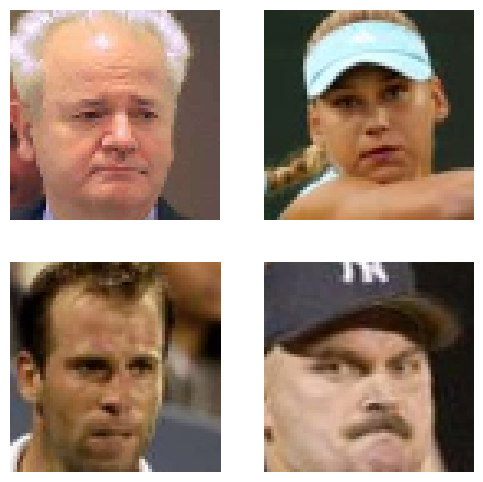

In [94]:
# parameters
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
])

# split train and test
train_subset_df, val_subset_df = train_test_split(train_df, test_size = 0.2, stratify = train_df['label'], random_state = 42)

# initialize custom datasets
train_dataset = TwoImageDataset(train_subset_df, transform = transform)
val_dataset = TwoImageDataset(val_subset_df, transform = transform)
test_dataset = TwoImageDataset(test_df, transform = transform, is_test = True)

# initialize custom dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

# check dataloader via example
print('> Example dataloaders image visualization\n')
ih.visualize_samples(train_dataloader, 4)

A continuación se inicia con la implementación de la red neuronal convolucional siamesa utilizando PyTorch,

In [112]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()

        # instance of resnet, get pretrained weights, take all except classification layer
        alexnet = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)
        # resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.conv1 = nn.Sequential(*list(alexnet.children())[:-1])

        # fully connected layers, executed after alexnet weights
        self.fc = nn.Sequential(
            # at the end of alexnet there is 256 channels and 6x6 dimensions after pooling, multiply 2 times cause of siamese
            # at the end transform the input features in a 512 vector of w
            nn.Linear(in_features = 256 * 6 * 6 * 2, out_features = 512, bias = True),
            nn.BatchNorm1d(512), # normalize layer for median 0 and variance 1 (mitigate gradient error)
            nn.LeakyReLU(negative_slope = 0.01), # non-linear activation function, 
            nn.Dropout(0.20),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope = 0.01),
            nn.Dropout(0.20),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        # print(out1.shape)
        
        concat = torch.cat((out1, out2), 1)
        # print(concat.shape)
        
        output = self.fc(concat)
        output = torch.flatten(output)
        # print(output)
        return output

    def train_cnn(self, train_loader, loss_fn, optimizer, scheduler=None, num_epochs=5):
        total_step = len(train_loader)
        list_loss = []
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0  # Variable para acumular la pérdida de la época
            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device)
    
                output = self(images1, images2)
                loss = loss_fn(output, labels)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss.item()  # Acumula la pérdida
                list_loss.append(loss.item())
                i += 1
    
                if (i + 1) % 10 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
            if scheduler:
                scheduler.step()
    
        print('Finished Training Trainset')
        return list_loss
    
    def predict(self, dataloader, with_labels=False):
        y_pred = []
        model.eval()
        with torch.no_grad():
            if not with_labels:
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            else:
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            return y_pred

In [113]:
epochs = 24
learning_rate = 0.0001
loss_fn = nn.BCELoss()

model = SiameseNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
scheduler = StepLR(optimizer = optimizer, step_size = 2, gamma = 0.1)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience = 3)

torch.cuda.empty_cache()
list_loss = model.train_cnn(train_dataloader, loss_fn, optimizer, scheduler = scheduler, num_epochs = epochs)

Epoch [1/24], Step [10/28], Loss: 0.7520774006843567
Epoch [1/24], Step [20/28], Loss: 0.6765574812889099
Epoch [2/24], Step [10/28], Loss: 0.5740744471549988
Epoch [2/24], Step [20/28], Loss: 0.5940568447113037
Epoch [3/24], Step [10/28], Loss: 0.4332997798919678
Epoch [3/24], Step [20/28], Loss: 0.5087014436721802
Epoch [4/24], Step [10/28], Loss: 0.4503155052661896
Epoch [4/24], Step [20/28], Loss: 0.4306202232837677
Epoch [5/24], Step [10/28], Loss: 0.4469794034957886
Epoch [5/24], Step [20/28], Loss: 0.3714011013507843
Epoch [6/24], Step [10/28], Loss: 0.44327419996261597
Epoch [6/24], Step [20/28], Loss: 0.40601232647895813
Epoch [7/24], Step [10/28], Loss: 0.4367857575416565
Epoch [7/24], Step [20/28], Loss: 0.4326780140399933
Epoch [8/24], Step [10/28], Loss: 0.428314208984375
Epoch [8/24], Step [20/28], Loss: 0.4207634925842285
Epoch [9/24], Step [10/28], Loss: 0.4099735617637634
Epoch [9/24], Step [20/28], Loss: 0.44450289011001587
Epoch [10/24], Step [10/28], Loss: 0.4004731

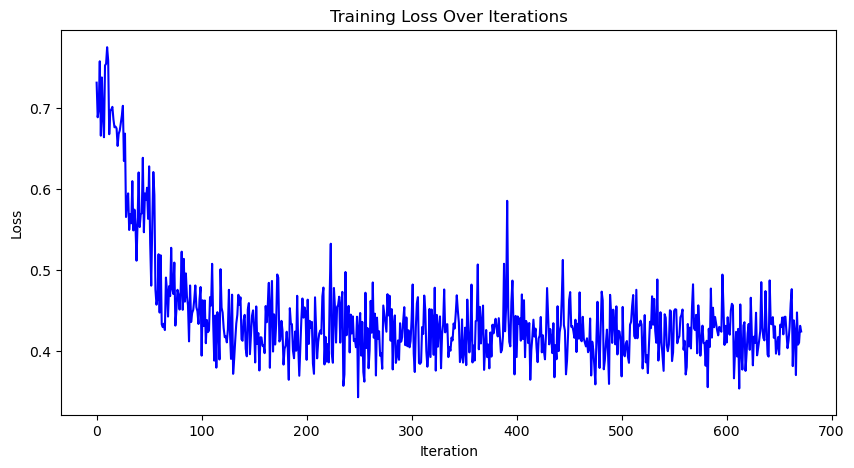

In [114]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       220
           1       0.62      0.72      0.67       220

    accuracy                           0.64       440
   macro avg       0.64      0.64      0.63       440
weighted avg       0.64      0.64      0.63       440



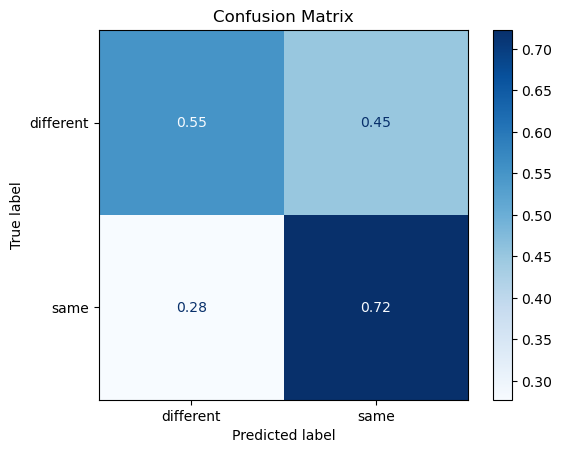

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred, normalize='true')

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [116]:
test_values = model.predict(test_dataloader)
print(np.unique(test_values))

[0 1]


## Modelo 2: ??

In [120]:
test_df_p4 = pd.read_csv("test.csv")  # Asegúrate de que tienes un archivo test.csv cargado

# Crear el DataFrame para la sumisión
submission_df = pd.DataFrame({
    'image1_image2': test_df_p4['image1_image2'],
    'label': ['same' if pred == 1 else 'diff' for pred in test_values]
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submission_p4.csv', index=False)

print("Submission saved to submission_p4.csv")

Submission saved to submission_p4.csv


## Experimentación

## Testing